# Библиотеки

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.models import Sequential
%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

2.12.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# загрузим подготовленный на предыдущем этапе датасет (объединенный, очищенный от шумов и выбросов)
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dataset/Копия1 X_CLEAR.xlsx') 

In [8]:
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
1,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
2,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
3,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
4,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


# **Нейронная сеть для Соотношения матрица-наполнитель**

В качестве метрики для оценки моделей возьмём среднюю абсолютную ошибку (**mae**) и коэффициент детерминации (**R2**)

Выделение предикторов и целевых переменных

In [9]:
# Признаки для 3-й задачи
y_columns = ['Соотношение матрица-наполнитель']
X_columns = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [10]:
y = df.loc[:, y_columns]
X = df.loc[:, X_columns]

In [12]:
# Разделяем на тренировочную и тестовую выборку
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48, shuffle=True)
print('X_train:', X_train_raw.shape, 'y1_train:', y_train.shape)
print('X_test:', X_test_raw.shape, 'y1_test:', y_test.shape)

X_train: (700, 12) y1_train: (700, 1)
X_test: (300, 12) y1_test: (300, 1)


In [13]:
# проверим правильность разбиения на выборки
df.shape[0] - X_train_raw.shape[0] - X_test_raw.shape[0]

0

In [14]:
# препроцессинг входных переменных
scaler = StandardScaler()
scaled1 = ColumnTransformer(transformers=[('scaler', scaler, X_columns)])
X_train = scaled1.fit_transform(X_train_raw)
X_test = scaled1.transform(X_test_raw)

In [15]:
#двумерные массивы y_train и y_test принимают исходные значения
y_train = y_train['Соотношение матрица-наполнитель'].values
y_test = y_test['Соотношение матрица-наполнитель'].values

In [16]:
print('X_train:', X_train.shape, 'y1_train:', y_train.shape)
print('X_test:', X_test.shape, 'y1_test:', y_test.shape)

X_train: (700, 12) y1_train: (700,)
X_test: (300, 12) y1_test: (300,)


Посмотрим описательную статистику до и после предобработки

In [236]:
X_train_raw.describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': [('text-align', 'left')]}])\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,1784.482,9.986,29.956,15.696,173.485,1.668,65.553,1036.857,41.048,0.000,0.145,20.572
max,2192.739,1649.416,192.852,28.955,396.898,1238.476,82.682,3848.437,386.903,1.000,14.376,89.877
mean,1972.982,744.270,110.904,22.222,284.521,472.354,73.371,2454.309,216.613,0.507,6.987,57.163
std,73.205,324.405,27.272,2.366,40.015,278.013,3.103,486.392,57.620,0.500,2.558,11.752


In [237]:
X_test_raw.describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': [('text-align', 'left')]}])\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,1786.036,2.437,33.624,16.668,189.867,0.604,64.054,1143.210,63.686,0.000,0.038,23.898
max,2182.752,1628.000,192.334,28.620,403.653,1291.340,82.526,3791.073,378.757,1.000,14.441,92.963
mean,1981.050,725.622,110.631,22.267,289.308,497.361,73.195,2489.493,222.082,0.470,6.732,57.542
std,72.171,334.942,29.262,2.430,40.602,276.669,3.141,481.696,61.856,0.500,2.552,12.078


In [238]:
pd.DataFrame(y_train, columns=y_columns).describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,Соотношение матрица-наполнитель
min,0.389
max,5.592
mean,2.926
std,0.923


In [239]:
pd.DataFrame(y_test, columns=y_columns).describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,Соотношение матрица-наполнитель
min,0.597
max,5.456
mean,2.961
std,0.876


После препроцессинга

In [240]:
pd.DataFrame(X_train, columns=X_columns).describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': [('text-align', 'left')]}])\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,-2.577,-2.265,-2.970,-2.760,-2.777,-1.694,-2.521,-2.916,-3.049,-1.014,-2.676,-3.116
max,3.004,2.792,3.007,2.848,2.810,2.758,3.003,2.868,2.958,0.986,2.890,2.786
mean,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001


In [241]:
pd.DataFrame(X_test, columns=X_columns).describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': [('text-align', 'left')]}])\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,-2.556,-2.288,-2.836,-2.349,-2.367,-1.698,-3.005,-2.697,-2.656,-1.014,-2.718,-2.833
max,2.868,2.726,2.988,2.706,2.979,2.948,2.952,2.750,2.816,0.986,2.915,3.049
mean,0.110,-0.058,-0.010,0.019,0.120,0.090,-0.057,0.072,0.095,-0.074,-0.100,0.032
std,0.987,1.033,1.074,1.028,1.015,0.996,1.013,0.991,1.074,1.000,0.998,1.028


In [242]:
pd.DataFrame(y_train, columns=y_columns).describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,Соотношение матрица-наполнитель
min,0.389
max,5.592
mean,2.926
std,0.923


In [243]:
pd.DataFrame(y_test, columns=y_columns).describe().loc[['min', 'max', 'mean', 'std'], :].style\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.3f}')

,Соотношение матрица-наполнитель
min,0.597
max,5.456
mean,2.961
std,0.876


# **Полносвязная нейронная сеть**

**Строим нейронную сеть с помощью библиотеки TensorFlow**

In [91]:
def build_compile_model():
    model = tf.keras.Sequential([
        keras.layers.Input(shape=(12,), name='in'),                   
        keras.layers.Dense(units=24, activation='relu', name='dense_1'),
        keras.layers.Dense(units=24, activation='relu', name='dense_2'),
        keras.layers.Dense(units=24, activation='relu', name='dense_3'),
        keras.layers.Dense(units=24, activation='relu', name='dense_4'),
        keras.layers.Dense(units=24, activation='relu', name='dense_5'),
        keras.layers.Dense(units=24, activation='relu', name='dense_6'),
        keras.layers.Dense(units=24, activation='relu', name='dense_7'),
        keras.layers.Dense(units=24, activation='relu', name='dense_8'),
        keras.layers.Dense(units=1, name='out')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanAbsolutePercentageError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    def plot_loss(history):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].plot(history['loss'], label='loss', color = 'r')
        axes[0].plot(history['val_loss'], label='val_loss', color = 'g')
        axes[0].set_xlabel('Эпоха')
        axes[0].set_ylabel('MAPE')
        axes[0].legend()
        axes[0].grid(True)
        axes[1].plot(history['root_mean_squared_error'], label='loss', color = 'r')
        axes[1].plot(history['val_root_mean_squared_error'], label='val_loss', color = 'g')
        axes[1].set_xlabel('Эпоха')
        axes[1].set_ylabel('RMSE')
        axes[1].legend()
        axes[1].grid(True)
        plt.show()
        
    return model, plot_loss

In [92]:
from keras.utils.vis_utils import plot_model

In [93]:
model, plot_loss = build_compile_model()

In [94]:
modelMF_1 = model, plot_loss

Отобразим архитектуру нейросети

In [95]:
modelMF_1[0].summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 24)                600       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 24)              

Эта нейросеть имеет один входной слой типа 'Input' с размерностью (12, 1), восемь скрытых слоев типа 'Dense' с функцией активации ReLU и по 24 нейрона в каждом слое, и один выходной слой 'Dense' с одним выходным нейроном. Каждый из скрытых слоев соединен со слоем, который находится перед ним и после него.

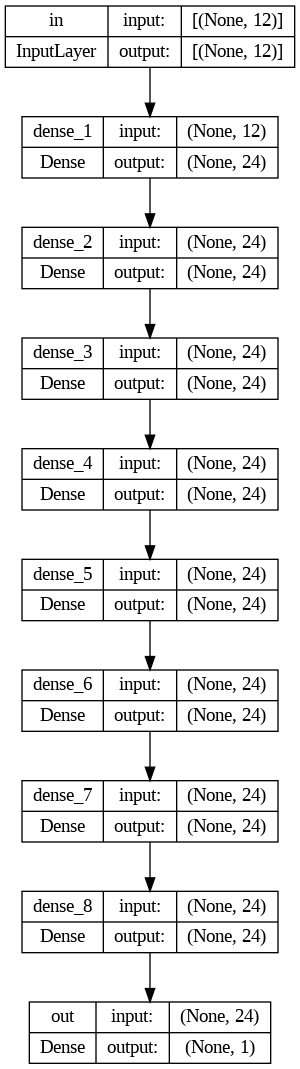

In [249]:
plot_model(modelMF_1[0], to_file='model.png', show_shapes=True)

Цель обучения - минимизировать значение функции потерь (как на тренировочных, так и на валидационных данных), чтобы достичь наилучшей обобщающей способности модели на тестовых данных. Когда значение val_loss начинает расти, это может быть признаком переобучения модели, т.е. она перестает обобщать результаты на новых данных.

Обучение модели

In [96]:
%%time
history = modelMF_1[0].fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.3,
    verbose=2
)

Epoch 1/20
16/16 - 3s - loss: 98.0721 - root_mean_squared_error: 3.0651 - val_loss: 92.7191 - val_root_mean_squared_error: 2.7827 - 3s/epoch - 177ms/step
Epoch 2/20
16/16 - 0s - loss: 81.5917 - root_mean_squared_error: 2.6698 - val_loss: 55.1668 - val_root_mean_squared_error: 1.8896 - 89ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 44.2780 - root_mean_squared_error: 1.5377 - val_loss: 40.6809 - val_root_mean_squared_error: 1.2555 - 88ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 38.6369 - root_mean_squared_error: 1.3518 - val_loss: 35.9436 - val_root_mean_squared_error: 1.2353 - 93ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 35.6534 - root_mean_squared_error: 1.2221 - val_loss: 35.7213 - val_root_mean_squared_error: 1.0773 - 94ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 33.9737 - root_mean_squared_error: 1.1127 - val_loss: 33.7594 - val_root_mean_squared_error: 1.1192 - 88ms/epoch - 6ms/step
Epoch 7/20
16/16 - 0s - loss: 33.3365 - root_mean_squared_error: 1.1394 - va

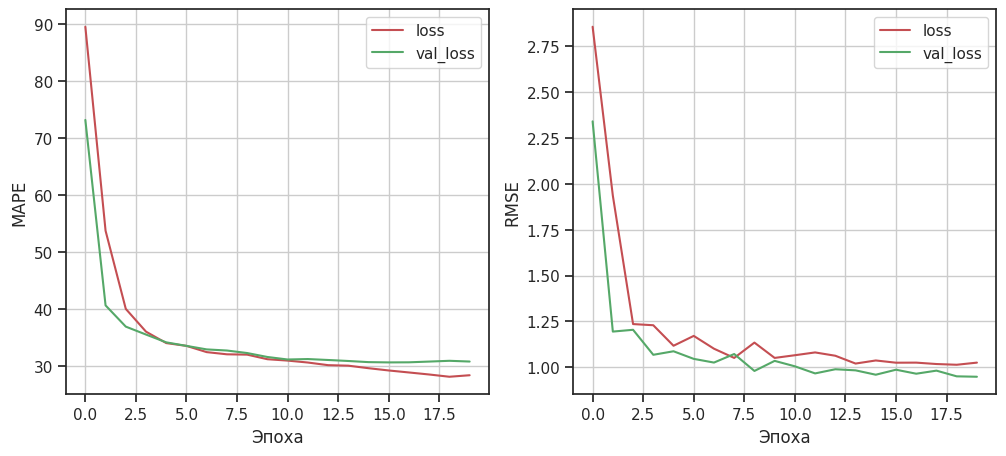

In [251]:
plot_loss(history.history)

На первом графике потерь по метрике MAPE видим, что нейросеть начала немного переобучаться.

На втором графике оцениваем качество модели. Признаки переобучения наблюдаем и здесь: val_loss (val_root_mean_squared_error) немного идёт на рост примерно от 16 эпохи.

In [252]:
# оцениваем точность нейросети на тестовых данных
modelMF_1[0].evaluate(X_test, y_test, verbose=1)

10/10 [==============================] - 0s 2ms/step - loss: 31.3712 - root_mean_squared_error: 1.0203


[31.37116241455078, 1.0203008651733398]

In [97]:
# Предсказание 
y_prediction_1 = modelMF_1[0].predict(X_test)

10/10 [==============================] - 0s 2ms/step


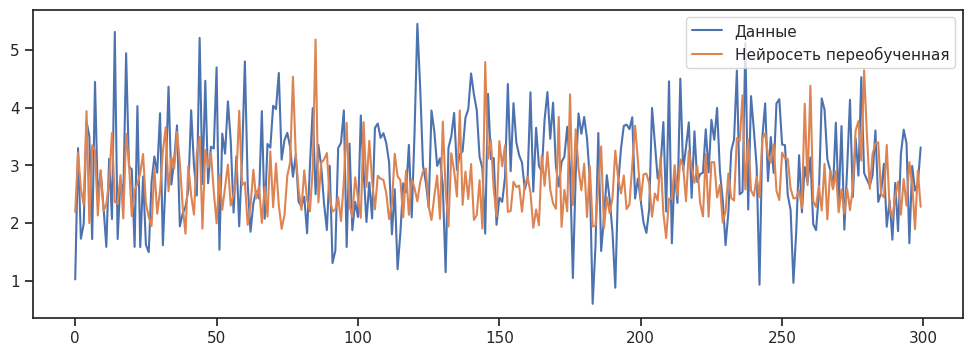

In [98]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='Данные')
ax.plot(y_prediction_1, label='Нейросеть переобученная')
ax.legend()
plt.show()

In [100]:
result = pd.DataFrame()
y1_pred_train = modeMF_1[0].predict(X_train)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тренировочный', y_train, y1_pred_train)])
y1_pred_test = modeMF_1[0].predict(X_test)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тестовый', y_test, y1_pred_test)])
result

NameError: ignored

Для борьбы с переобучением нейросети можно применить раннюю остановку процесса обучения.

In [255]:
model, plot_loss = build_compile_model()

In [256]:
# используем на той же архитектуре
modelMF_2 = model, plot_loss
modelMF_2[0].summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 24)                600       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 24)              

In [257]:
%%time
history = modelMF_2[0].fit(
    X_train,
    y_train,
    epochs=24,
    validation_split=0.3,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/24
16/16 [==============================] - 2s 18ms/step - loss: 98.4737 - root_mean_squared_error: 3.0731 - val_loss: 95.3768 - val_root_mean_squared_error: 2.8498
Epoch 2/24
16/16 [==============================] - 0s 5ms/step - loss: 90.2380 - root_mean_squared_error: 2.8720 - val_loss: 78.5662 - val_root_mean_squared_error: 2.4482
Epoch 3/24
16/16 [==============================] - 0s 4ms/step - loss: 57.9212 - root_mean_squared_error: 2.0431 - val_loss: 35.6655 - val_root_mean_squared_error: 1.0791
Epoch 4/24
16/16 [==============================] - 0s 3ms/step - loss: 37.8218 - root_mean_squared_error: 1.2125 - val_loss: 32.5600 - val_root_mean_squared_error: 1.0802
Epoch 5/24
16/16 [==============================] - 0s 4ms/step - loss: 34.6105 - root_mean_squared_error: 1.1809 - val_loss: 31.5501 - val_root_mean_squared_error: 1.0472
Epoch 6/24
16/16 [==============================] - 0s 20ms/step - loss: 33.3340 - root_mean_squared_error: 1.1789 - val_loss: 30.9627 - va

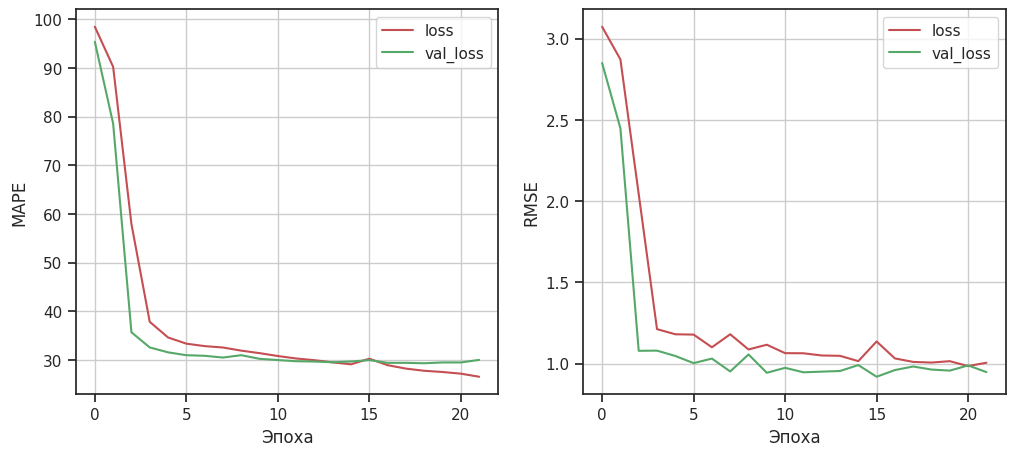

In [258]:
plot_loss(history.history)

In [259]:
# оцениваем точность нейросети на тестовых данных
modelMF_2[0].evaluate(X_test, y_test, verbose=1)

10/10 [==============================] - 0s 1ms/step - loss: 30.5831 - root_mean_squared_error: 1.0041


[30.583091735839844, 1.0040587186813354]

In [260]:
# Предсказание 
y_prediction_2 = modelMF_2[0].predict(X_test)

10/10 [==============================] - 0s 1ms/step


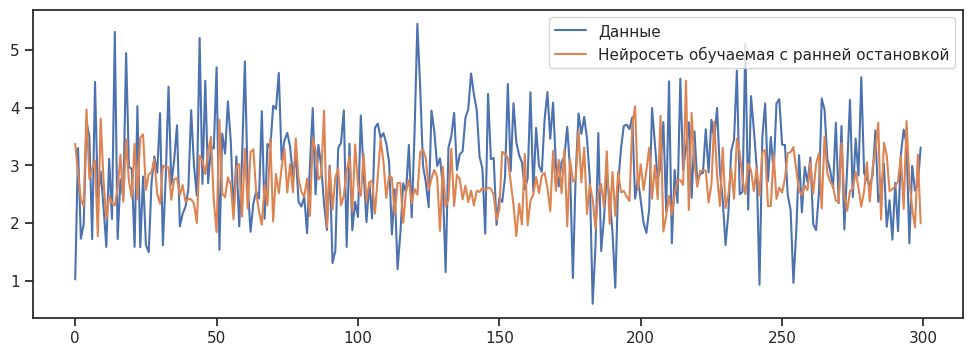

In [261]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='Данные')
ax.plot(y_prediction_2, label='Нейросеть обучаемая с ранней остановкой')
ax.legend()
plt.show()

In [89]:
result = pd.DataFrame()
y2_pred_train = modeMF_2.predict(X_train)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тренировочный', y_train, y2_pred_train)])
y2_pred_test = modeMF_2.predict(X_test)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тестовый', y_test, y2_pred_test)])
result

NameError: ignored

Также ещё одним методом для борьбы переобучения нейросети является дополнение Dropout-слоя

In [269]:
# Построение аналогичной модели с Dropout слоем
modeMF_3 = tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='softmax', name='dense_1'),
      keras.layers.Dropout(0.05, name='dropout_1'),
      keras.layers.Dense(units=24, activation='sigmoid', name='dense_2'),
      keras.layers.Dropout(0.05, name='dropout_2'),
      keras.layers.Dense(units=24, activation='sigmoid', name='dense_3'),
      keras.layers.Dropout(0.05, name='dropout_3'),
      keras.layers.Dense(units=24, activation='sigmoid', name='dense_4'),
      keras.layers.Dropout(0.05, name='dropout_4'),
      keras.layers.Dense(units=24, activation='sigmoid', name='dense_5'),
      keras.layers.Dropout(0.05, name='dropout_5'),
      keras.layers.Dense(units=24, activation='sigmoid', name='dense_6'),
      keras.layers.Dropout(0.05, name='dropout_6'),
      keras.layers.Dense(units=24, activation='sigmoid', name='dense_7'),
      keras.layers.Dropout(0.05, name='dropout_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dropout(0.05, name='dropout_8'),
      keras.layers.Dense(units=1, name='out')                        
    ])

In [270]:
def compile_model(model):
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.MeanAbsolutePercentageError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

Компилируем модель

In [276]:
modeMF_3 = compile_model(modeMF_3)

In [272]:
# архитектура с Dropout-слоем
modeMF_3.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 24)              

In [273]:
%%time
# обучение нейросети с Dropout-слоями
history = modeMF_3.fit(
  X_train, 
  y_train, 
  epochs=20, 
  validation_split=0.1, 
  verbose=2
)

Epoch 1/20
20/20 - 2s - loss: 84.9804 - root_mean_squared_error: 2.7279 - val_loss: 70.6117 - val_root_mean_squared_error: 2.1250 - 2s/epoch - 81ms/step
Epoch 2/20
20/20 - 0s - loss: 60.3118 - root_mean_squared_error: 2.1058 - val_loss: 43.8948 - val_root_mean_squared_error: 1.4677 - 66ms/epoch - 3ms/step
Epoch 3/20
20/20 - 0s - loss: 39.0023 - root_mean_squared_error: 1.4278 - val_loss: 24.5960 - val_root_mean_squared_error: 0.8002 - 73ms/epoch - 4ms/step
Epoch 4/20
20/20 - 0s - loss: 32.6899 - root_mean_squared_error: 1.0480 - val_loss: 25.1177 - val_root_mean_squared_error: 0.7681 - 56ms/epoch - 3ms/step
Epoch 5/20
20/20 - 0s - loss: 31.8886 - root_mean_squared_error: 1.0619 - val_loss: 24.6067 - val_root_mean_squared_error: 0.7888 - 54ms/epoch - 3ms/step
Epoch 6/20
20/20 - 0s - loss: 32.3635 - root_mean_squared_error: 1.0977 - val_loss: 24.7275 - val_root_mean_squared_error: 0.7772 - 61ms/epoch - 3ms/step
Epoch 7/20
20/20 - 0s - loss: 31.7158 - root_mean_squared_error: 1.0685 - val

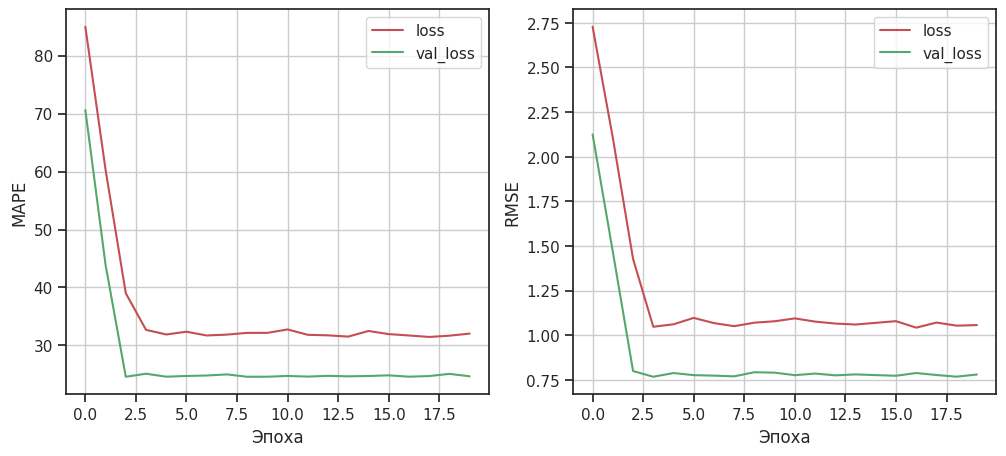

In [274]:
plot_loss(history.history)

In [277]:
# оцениваем точность нейросети на тестовых данных
modeMF_3.evaluate(X_test, y_test, verbose=1)

10/10 [==============================] - 0s 1ms/step - loss: 28.3274 - root_mean_squared_error: 0.9749


[28.327438354492188, 0.9749125242233276]

In [280]:
# Предсказание 
y_prediction_3 = modeMF_3.predict(X_test)

10/10 [==============================] - 0s 1ms/step


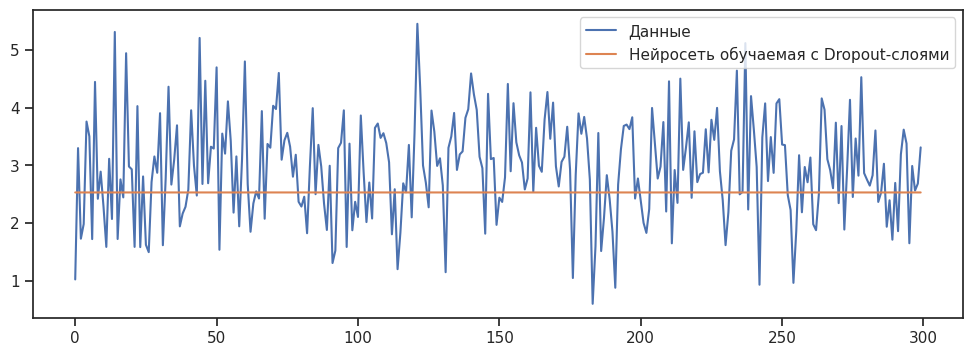

In [282]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='Данные')
ax.plot(y_prediction_3, label='Нейросеть обучаемая с Dropout-слоями')
ax.legend()
plt.show()

In [83]:
from sklearn import metrics

In [84]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred, squared=False) * -1
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred) * -1
    stat.loc[model_name, 'MAPE'] = metrics.mean_absolute_percentage_error(y, y_pred) * -1
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred) * -1
    return stat

In [287]:
result = pd.DataFrame()
y3_pred_train = modeMF_3.predict(X_train)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тренировочный', y_train, y3_pred_train)])
y3_pred_test = modeMF_3.predict(X_test)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тестовый', y_test, y3_pred_test)])
result

10/10 [==============================] - 0s 1ms/step


,R2,RMSE,MAE,MAPE,max_error
"Соотношение матрица-наполнитель, тренировочный",-0.184964,-1.004083,-0.796417,-0.300597,-3.062634
"Соотношение матрица-наполнитель, тестовый",-0.243903,-0.974912,-0.782955,-0.283274,-2.926466


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 100)               1300      
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_147 (Dense)           (None, 50)                5050      
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 50)                0         
                                                                 
 dropout_22 (Dropout)        (None, 50)                0         
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 50)                0         
                                                                 
 dense_148 (Dense)           (None, 1)               

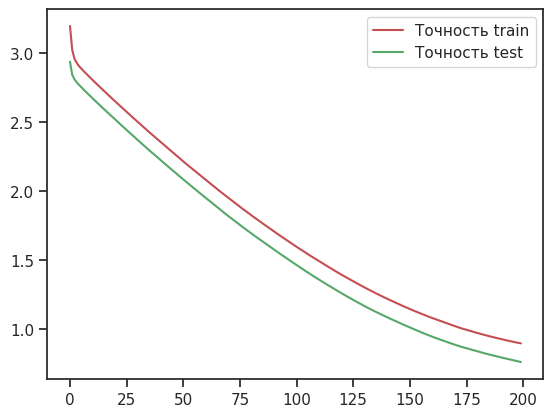

In [87]:
modeMF_4= Sequential()
modeMF_4.add(Dense(100, input_dim=12, activation='sigmoid'))
modeMF_4.add(LeakyReLU(alpha=1.0))
modeMF_4.add(Dense(50, input_dim=12, activation='sigmoid'))
modeMF_4.add(LeakyReLU(alpha=1.0))

modeMF_4.add(Dropout(0.5))
modeMF_4.add(LeakyReLU(alpha=1.0))
modeMF_4.add(Dense(1, activation='sigmoid'))

#IMPORTANT PART
modeMF_4.add(Dense(1, activation='linear'))
modeMF_4.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

modeMF_4.summary()
history = modeMF_4.fit(X_train,y_train, 
                    epochs=200, 
                    validation_split=0.3, 
                    verbose=1)
plt.plot(history.history['mean_absolute_error'], label = 'Точность train', color = 'r')
plt.plot(history.history['val_mean_absolute_error'], label = 'Точность test', color = 'g')
plt.xlabel = ('Эпоха')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

In [88]:
# оцениваем точность нейросети на тестовых данных
modeMF_4.evaluate(X_test, y_test, verbose=1)

10/10 [==============================] - 0s 2ms/step - loss: 1.0972 - mean_absolute_error: 0.8469


[1.0972169637680054, 0.8469181656837463]

In [80]:
# Предсказание 
y_prediction_4 = modeMF_4.predict(X_test)

10/10 [==============================] - 0s 2ms/step


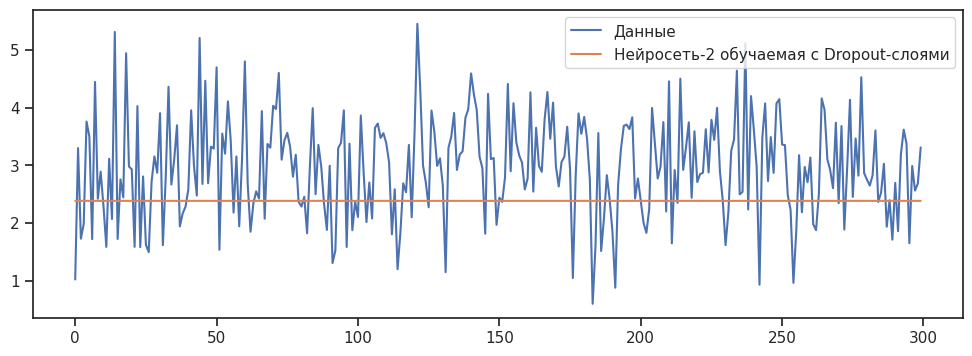

In [82]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='Данные')
ax.plot(y_prediction_4, label='Нейросеть-2 обучаемая с Dropout-слоями')
ax.legend()
plt.show()

In [86]:
result = pd.DataFrame()
y4_prediction_train = modeMF_4.predict(X_train)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тренировочный', y4_prediction_train, y_train)])
y4_prediction_test = modeMF_4.predict(X_test)
result = pd.concat([result, get_metrics('Соотношение матрица-наполнитель, тестовый', y4_prediction_test, y_test)])
result

10/10 [==============================] - 0s 2ms/step


,R2,RMSE,MAE,MAPE,max_error
"Соотношение матрица-наполнитель, тренировочный",-2.227805e+12,-1.070118,-0.852494,-0.357699,-3.208471
"Соотношение матрица-наполнитель, тестовый",-2.135239e+12,-1.047677,-0.847099,-0.355435,-3.072297


In [292]:
modeMF_2[0].save('/content/drive/MyDrive/Colab Notebooks/NN/modeMF_2/')

NameError: ignored

In [290]:
modeMF_2.save('/content/drive/MyDrive/Colab Notebooks/NN/modeMF_1/')

NameError: ignored

In [289]:
modeMF_3.save('/content/drive/MyDrive/Colab Notebooks/NN/modeMF_3/')

временные ячейки - начало -----

In [ ]:
# попробуем нормализацию  данных с помощью MinMaxScaler
scaler_norm = MinMaxScaler()
scaler_norm.fit(X)
Xnorm = pd.DataFrame (data =scaler_norm.transform(X), columns=X.columns)
scaler_norm_y = MinMaxScaler()
scaler_norm_y.fit(y)
ynorm = pd.DataFrame (data = scaler_norm_y.transform(y), columns=y.columns)

In [ ]:
#разбиение нормализованных данных на тестовую и тренировочную часть
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(Xnorm,ynorm, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
df.shape[0] - X_train_norm.shape[0] - X_test_norm.shape[0]

0

Проверяем выборки после нормализации

In [ ]:
X_train_norm.shape

(700, 12)

In [ ]:
X_test_norm.shape

(300, 12)

In [ ]:
y_train_norm.shape


(700, 1)

In [ ]:
y_test_norm.shape

(300, 1)

Посмотрим описательную статистику нормализованных данных тенировочной выборки

In [ ]:
X_train_norm.describe().T.style\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': [('text-align', 'left')]}])\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.4f}')

,count,mean,std,min,25%,50%,75%,max
"Плотность, кг/м3",700.0000,0.4600,0.1792,0.0000,0.3315,0.4561,0.5773,1.0000
"модуль упругости, ГПа",700.0000,0.4470,0.1980,0.0000,0.3009,0.4471,0.5790,1.0000
"Количество отвердителя, м.%",700.0000,0.5044,0.1722,0.0225,0.3860,0.5046,0.6207,1.0000
"Содержание эпоксидных групп,%_2",700.0000,0.4890,0.1761,0.0000,0.3700,0.4869,0.6177,0.9964
"Температура вспышки, С_2",700.0000,0.4908,0.1766,0.0021,0.3703,0.4906,0.6092,1.0000
"Поверхностная плотность, г/м2",700.0000,0.3728,0.2156,0.0008,0.2064,0.3586,0.5319,0.9979
"Модуль упругости при растяжении, ГПа",700.0000,0.5016,0.1680,0.0000,0.3900,0.5002,0.6150,0.9761
"Прочность при растяжении, МПа",700.0000,0.5094,0.1755,0.0122,0.3909,0.5047,0.6207,1.0000
"Потребление смолы, г/м2",700.0000,0.5083,0.1680,0.0000,0.3932,0.5074,0.6198,1.0000
"Угол нашивки, град",700.0000,0.4957,0.5003,0.0000,0.0000,0.0000,1.0000,1.0000


Так выглядело до нормализации

In [ ]:
X_train.describe().T.style\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': [('text-align', 'left')]}])\
    .set_properties(**{'text-align': 'left'})\
    .format('{:.4f}')

,count,mean,std,min,25%,50%,75%,max
"Плотность, кг/м3",700.0000,1972.2865,73.1483,1784.4822,1919.8335,1970.7075,2020.1886,2192.7388
"модуль упругости, ГПа",700.0000,738.6276,326.1306,2.4369,498.0316,738.8470,955.9619,1649.4157
"Количество отвердителя, м.%",700.0000,112.1192,28.0565,33.6242,92.8415,112.1462,131.0734,192.8517
"Содержание эпоксидных групп,%_2",700.0000,22.1791,2.3351,15.6959,20.6023,22.1514,23.8864,28.9075
"Температура вспышки, С_2",700.0000,286.4496,40.6451,173.9739,258.7142,286.3969,313.6955,403.6529
"Поверхностная плотность, г/м2",700.0000,481.8059,278.2536,1.6680,266.9787,463.5063,687.1801,1288.6918
"Модуль упругости при растяжении, ГПа",700.0000,73.3988,3.1286,64.0541,71.3196,73.3722,75.5102,82.2376
"Прочность при растяжении, МПа",700.0000,2469.1092,493.5317,1071.1238,2135.8861,2455.9745,2782.1120,3848.4367
"Потребление смолы, г/м2",700.0000,216.8385,58.1081,41.0483,177.0368,216.5419,255.4087,386.9034
"Угол нашивки, град",700.0000,0.4957,0.5003,0.0000,0.0000,0.0000,1.0000,1.0000


------- конец -- временные ячейки 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
20/20 - 1s - loss: 0.0424 - mae: 0.1652 - val_loss: 0.0279 - val_mae: 0.1360 - 1s/epoch - 65ms/step
Epoch 2/150
20/20 - 0s - loss: 0.0387 - mae: 0.1583 - val_loss: 0.0262 - val_m

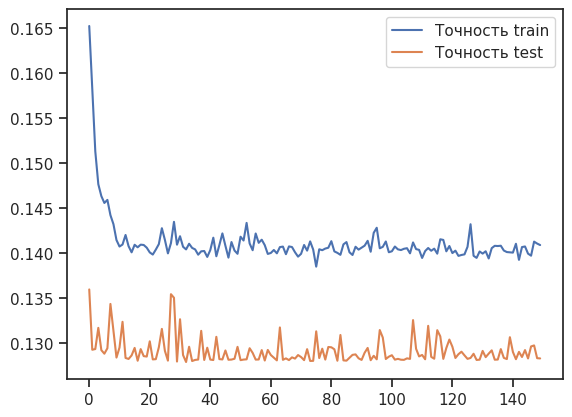

In [ ]:
# модель полносвязной нейронной сети для целевой переменной y1
modelNN_y = Sequential()
modelNN_y.add(Dense(16,  input_dim=12, activation = 'sigmoid'))
modelNN_y.add(Dropout(0.5))
modelNN_y.add(Dense(32, activation = 'sigmoid'))
modelNN_y.add(Dense(1, activation = 'tanh'))
modelNN_y.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y.summary()
history = modelNN_y.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                208       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
20/20 - 2s - loss: 0.0591 - mae: 0.1949 - val_loss: 0.0299 - val_mae: 0.1404 - 2s/epoch - 90ms/step
Epoch 2/150
20/20 - 0s - loss: 0.0502 - mae: 0.1786 - val_loss: 0.0268 - val

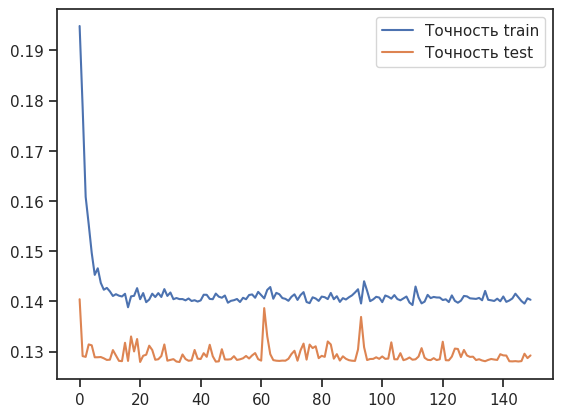

In [ ]:
# модель полносвязной нейронной сети тренируем на нормализованных данных
modelNN_y1 = Sequential()
modelNN_y1.add(Dense(16,  input_dim=12, activation = 'sigmoid'))
modelNN_y1.add(Dropout(0.5))
modelNN_y1.add(Dense(32, activation = 'sigmoid'))
modelNN_y1.add(Dense(1, activation = 'relu'))
modelNN_y1.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y1.summary()
history = modelNN_y1.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                416       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 1)                

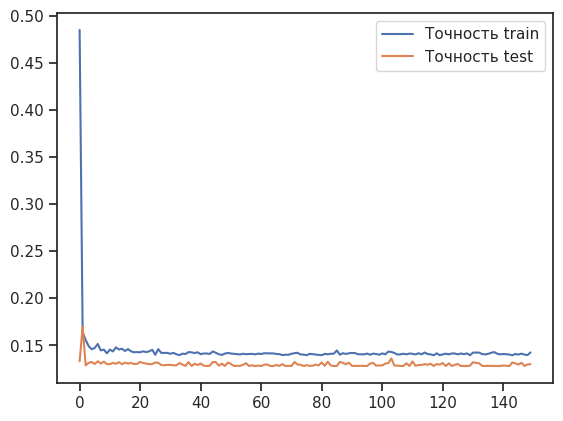

In [ ]:
# модель полносвязной нейронной сети тренируем на нормализованных данных
modelNN_y2 = Sequential([
                Dense(32,  input_dim=12, activation = 'sigmoid'),
                Dropout(0.5),
                Dense(64, activation = 'sigmoid'),
                Dropout(0.5),
                Dense(32, activation = 'sigmoid'),
                Dense(16, activation = 'sigmoid'),
                Dense(1, activation = 'linear')])
modelNN_y2.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y2.summary()
history = modelNN_y2.fit(X_train_norm,y_train_norm.iloc[:,0], 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16)                208       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-traina

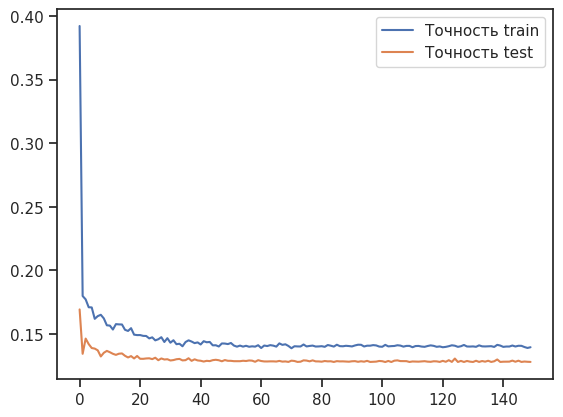

In [ ]:
# модель полносвязной нейронной сети для целевого параметра y3 тренируем на нормализованных данных
modelNN_y3 = Sequential()
modelNN_y3.add(Dense(16,  input_dim=12, activation = 'sigmoid'))
modelNN_y3.add(Dropout(0.5))
modelNN_y3.add(Dense(32, activation = 'sigmoid'))
modelNN_y3.add(Dropout(0.5))
modelNN_y3.add(Dense(16, activation = 'sigmoid'))
modelNN_y3.add(Dense(1, activation = 'tanh'))
modelNN_y3.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y3.summary()
history = modelNN_y3.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                832       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-traina

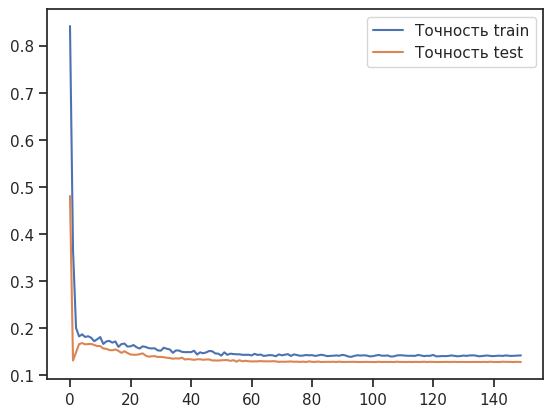

In [ ]:
# модель полносвязной нейронной сети для целевого параметра y4 тренируем на нормализованных данных
modelNN_y4 = Sequential()
modelNN_y4.add(Dense(64,  input_dim=12, activation = 'sigmoid'))
modelNN_y4.add(Dropout(0.5))
modelNN_y4.add(Dense(32, activation = 'sigmoid'))
modelNN_y4.add(Dropout(0.5))
modelNN_y4.add(Dense(16, activation = 'sigmoid'))
modelNN_y4.add(Dense(1, activation = 'tanh'))
modelNN_y4.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y4.summary()
history = modelNN_y4.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               1664      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 16)               

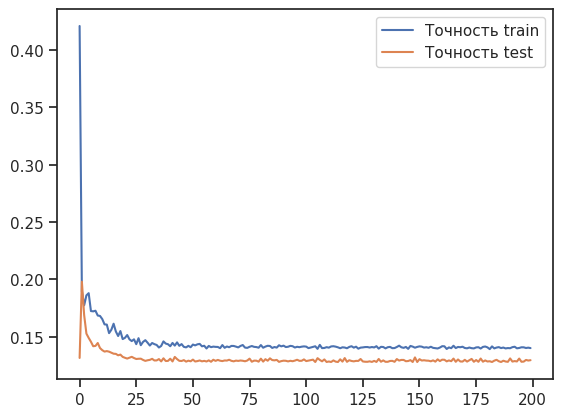

In [ ]:
# модель полносвязной нейронной сети для целевого параметра y4 тренируем на нормализованных данных
modelNN_y4 = Sequential()
modelNN_y4.add(Dense(128,  input_dim=12, activation = 'sigmoid'))
modelNN_y4.add(Dropout(0.5))
modelNN_y4.add(Dense(64, activation = 'sigmoid'))
modelNN_y4.add(Dropout(0.5))
modelNN_y4.add(Dense(32, activation = 'sigmoid'))
modelNN_y4.add(Dropout(0.5))
modelNN_y4.add(Dense(16, activation = 'sigmoid'))
modelNN_y4.add(Dense(1, activation = 'tanh'))
modelNN_y4.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y4.summary()
history = modelNN_y4.fit(X_train_norm,y_train_norm, 
                    epochs=200, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               1300      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 50)                5050      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
 dense_27 (Dense)            (None, 1)                 2         
                                                                 
Total params: 6,403
Trainable params: 6,403
Non-traina

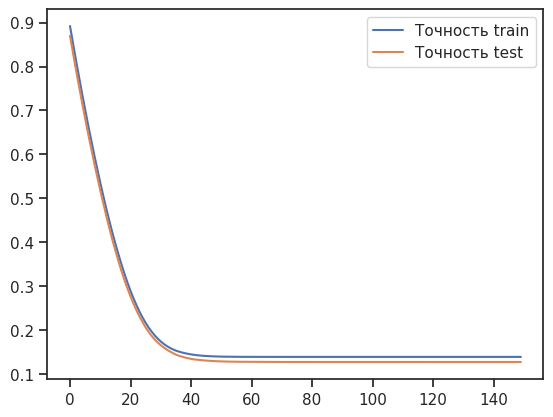

In [ ]:
# 5 
model_y5= Sequential()
model_y5.add(Dense(100, input_dim=12, activation='sigmoid'))
model_y5.add(LeakyReLU(alpha=1.0))
model_y5.add(Dense(50, activation='sigmoid'))
model_y5.add(LeakyReLU(alpha=1.0))
model_y5.add(Dense(1, activation='softmax'))

#IMPORTANT PART
model_y5.add(Dense(1, activation='linear'))
model_y5.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_y5.summary()
history = model_y5.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 100)               1300      
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 50)                5050      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 25)                1275      
                                                                 
 dense_31 (Dense)            (None, 1)                

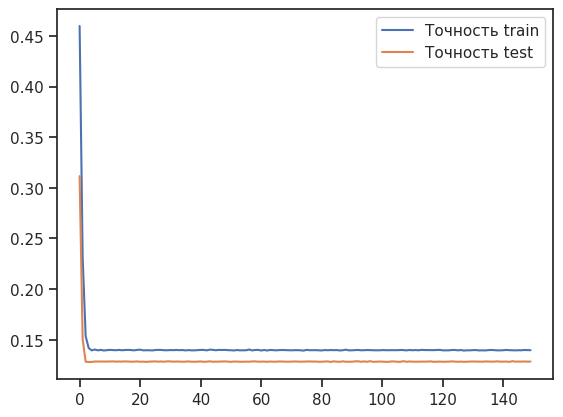

In [ ]:
# 6
model_y6= Sequential()
model_y6.add(Dense(100, input_dim=12, activation='sigmoid'))
model_y6.add(Dropout(0.5))
model_y6.add(LeakyReLU(alpha=1.0))
model_y6.add(Dense(50, activation='sigmoid'))
model_y6.add(LeakyReLU(alpha=1.0))
model_y6.add(Dense(25, activation='softmax'))

#IMPORTANT PART
model_y6.add(Dense(1, activation='linear'))
model_y6.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_y6.summary()
history = model_y6.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 16)                208       
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 8)                 136       
                                                                 
 dense_34 (Dense)            (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
20/20 - 1s - loss: 0.3233 - mae: 0.5161 - va

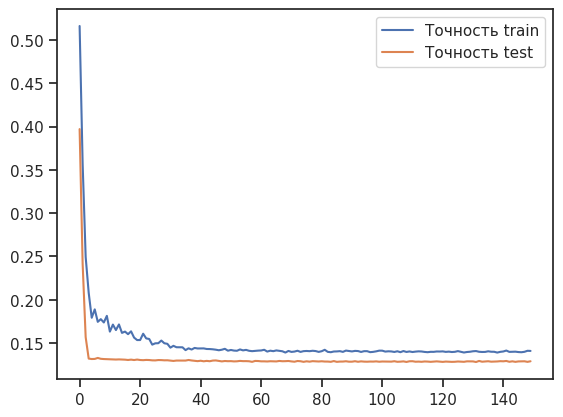

In [ ]:
# 7
model_y7= Sequential()
model_y7.add(Dense(16, input_dim=12, activation='sigmoid'))
model_y7.add(Dropout(0.5))
model_y7.add(LeakyReLU(alpha=1.0))
model_y7.add(Dense(8, activation='sigmoid'))

#IMPORTANT PART
model_y7.add(Dense(1, activation='linear'))
model_y7.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_y7.summary()
history = model_y7.fit(X_train_norm,y_train_norm, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

In [ ]:
y_pred = modelNN_y.predict(X_test_norm)
y_pred_1 = modelNN_y1.predict(X_test_norm)
y_pred_2 = modelNN_y2.predict(X_test_norm)
y_pred_3 = modelNN_y3.predict(X_test_norm)
y_pred_4 = modelNN_y4.predict(X_test_norm)
y_pred_5 = model_y5.predict(X_test_norm)
y_pred_6 = model_y6.predict(X_test_norm)
y_pred_7 = model_y7.predict(X_test_norm)

y_pred = scaler_norm_y.inverse_transform (y_pred)
y_pred1 = scaler_norm_y.inverse_transform (y_pred_1)
y_pred2 = scaler_norm_y.inverse_transform (y_pred_2)
y_pred3 = scaler_norm_y.inverse_transform (y_pred_3)
y_pred4 = scaler_norm_y.inverse_transform (y_pred_4)
y_pred5 = scaler_norm_y.inverse_transform (y_pred_5)
y_pred6 = scaler_norm_y.inverse_transform (y_pred_6)
y_pred7 = scaler_norm_y.inverse_transform (y_pred_7)

MAE_0 = mean_absolute_error(y_test,y_pred)
print (MAE_0)
MAE_1 = mean_absolute_error(y_test,y_pred1)
print (MAE_1)
MAE_2 = mean_absolute_error(y_test,y_pred2)
print (MAE_2)
MAE_3 = mean_absolute_error(y_test,y_pred3)
print (MAE_3)
MAE_4 = mean_absolute_error(y_test,y_pred4)
print (MAE_4)
MAE_5 = mean_absolute_error(y_test,y_pred5)
print (MAE_5)
MAE_6 = mean_absolute_error(y_test,y_pred6)
print (MAE_6)
MAE_7 = mean_absolute_error(y_test,y_pred7)
print (MAE_7)

10/10 [==============================] - 0s 2ms/step
0.7363657054215353
0.7429863618259119
0.7507257556551467
0.7381061820379768
0.7485890578859816
0.7390058728249743
0.7405408752155179
0.7431421636440246


In [ ]:
# записываем данные об ошибках в итоговую таблицу
MAE.append(['Нейросеть 0',MAE_0])
MAE.append(['Нейросеть 1',MAE_1])
MAE.append(['Нейросеть 2',MAE_2])
MAE.append(['Нейросеть 3',MAE_3])
MAE.append(['Нейросеть 4',MAE_4])
MAE.append(['Нейросеть 5',MAE_5])
MAE.append(['Нейросеть 6',MAE_6])
MAE.append(['Нейросеть 7',MAE_7])

In [ ]:
# Результаты расчета ошибок нейросетей при предсказании целевого признака "Соотношение матрица-наполнитель"
MAE

[['Нейросеть 0', 0.7363657054215353],
 ['Нейросеть 1', 0.7429863618259119],
 ['Нейросеть 2', 0.7507257556551467],
 ['Нейросеть 3', 0.7381061820379768],
 ['Нейросеть 4', 0.7485890578859816],
 ['Нейросеть 5', 0.7390058728249743],
 ['Нейросеть 6', 0.7405408752155179],
 ['Нейросеть 7', 0.7431421636440246]]

In [ ]:
#  результаты MAE
a = np.array(MAE)

MAE_errors = pd.DataFrame({'Версия нейросети': a[:,0], 'MAE Соотношение матрица-наполнитель': a[:,1]})
MAE_errors = MAE_errors.astype({'MAE Соотношение матрица-наполнитель': np.float16})
MAE_errors

,Версия нейросети,MAE Соотношение матрица-наполнитель
0,Нейросеть 0,0.736328
1,Нейросеть 1,0.743164
2,Нейросеть 2,0.750488
3,Нейросеть 3,0.738281
4,Нейросеть 4,0.748535
5,Нейросеть 5,0.738770
6,Нейросеть 6,0.740723
7,Нейросеть 7,0.743164


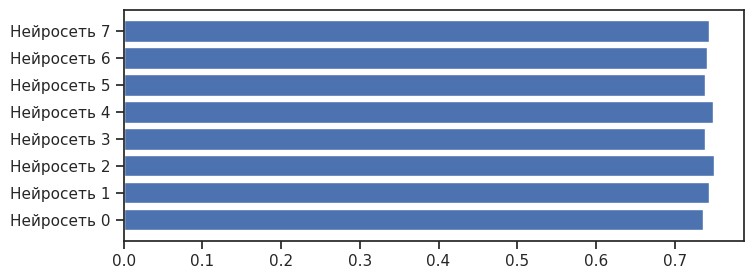

In [ ]:
# Гистограмма распределения ошибки
plt.figure(figsize=(8, 3))
plt.barh(MAE_errors['Версия нейросети'], MAE_errors['MAE Соотношение матрица-наполнитель'])
plt.show()

In [ ]:
# Запишем результаты сравнения в файл
MAE_errors.to_excel('/content/drive/MyDrive/Colab Notebooks/dataset/MAE_errors.xlsx', index=0)


In [ ]:
df.to_excel('/content/drive/MyDrive/Colab Notebooks/dataset/R2_errors.xlsx', index=0)

In [ ]:
model_y5.save('mn_model_nn')

In [ ]:
model_y5.save('/content/drive/MyDrive/Colab Notebooks/mn_model_nn')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 100)               1300      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_36 (Dense)            (None, 50)                5050      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 50)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 51        
                                                                 
 dense_38 (Dense)            (None, 1)                 2         
                                                                 
Total params: 6,403
Trainable params: 6,403
Non-traina

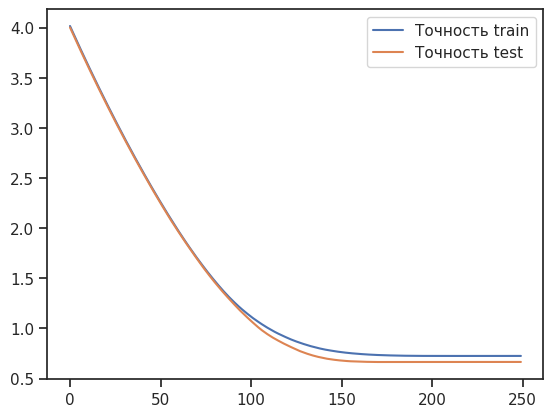

In [ ]:
# НС на исходных очищенных данных (не нормализованных) 
model= Sequential()
model.add(Dense(100, input_dim=12, activation='sigmoid'))
model.add(LeakyReLU(alpha=1.0))
model.add(Dense(50, activation='sigmoid'))
model.add(LeakyReLU(alpha=1.0))
model.add(Dense(1, activation='softmax'))

#IMPORTANT PART
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()
history = model.fit(X_train,y_train, 
                    epochs=250, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

In [ ]:
y_pr = model.predict(X_test)
MAE = mean_absolute_error(y_test,y_pr)
print (MAE)

10/10 [==============================] - 0s 2ms/step
0.739148881057091


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/mn_model_nn1')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                416       
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_40 (Dense)            (None, 16)                528       
                                                                 
 dense_41 (Dense)            (None, 1)                 17        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
20/20 - 2s - loss: 6.9055 - mae: 2.4533 - v

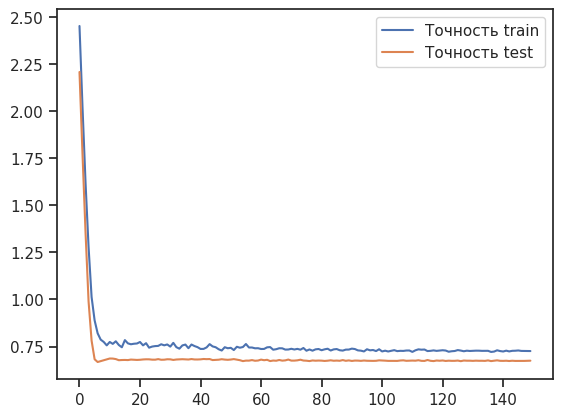

In [ ]:
# 8
model_y8= Sequential()
model_y8.add(Dense(32, input_dim=12, activation='sigmoid'))
model_y8.add(Dropout(0.5))
model_y8.add(LeakyReLU(alpha=1.0))
model_y8.add(Dense(16, activation='sigmoid'))

#IMPORTANT PART
model_y8.add(Dense(1, activation='linear'))
model_y8.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_y8.summary()
history = model_y8.fit(X_train,y_train, 
                    epochs=150, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

In [ ]:
y_pr8 = model_y8.predict(X_test)
MAE = mean_absolute_error(y_test,y_pr8)
print (MAE)

10/10 [==============================] - 0s 2ms/step
0.7428098056268093


In [ ]:
model_y8.save('mn_model_nn8')

In [ ]:
model_y8.save('/content/drive/MyDrive/Colab Notebooks/mn_model_nn8')